this script calculate the kl value of countries after "international funded" publications are removed and plot the kl value to the worldmap and aggregate countries by continents.

The inputs includes:
- the actual publication record
- the filtered publication record

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import funding.core
from scipy.special import rel_entr
import geopandas as gp
import seaborn as sns

In [2]:
cntry_full_path="../../data/nf_folder/Data/DerivedData/Derived/cntry_author_full.csv"
cntry_filter_path='../../data/nf_folder/Data/DerivedData/Derived/dep-FundInternational/pub_noInt_fund.csv'
geopath="../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

plot_path='/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/dependence_NoForeignFund/profile_change_global.pdf'

In [3]:
# Parameters
cntry_full_path = "../data/NationalFunding/Data/simulated_data/Data/DerivedData/Derived/cntry_author_full.csv"
cntry_filter_path = "../data/NationalFunding/Data/simulated_data/Data/DerivedData/Derived/dependence/pub_no_exclusive_int_fund.csv"
geopath = "../data/NationalFunding/Data/simulated_data/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"
region_path = (
    "../data/NationalFunding/Data/simulated_data/Data/AdditionalData/cntry_region.xlsx"
)
plot_path = "../data/NationalFunding/Data/simulated_data/Figs/Figs/dependence_NoForeignFund/pub_change_no_exclusive_global.pdf"


In [4]:
raw_df=pd.read_csv(cntry_full_path)
raw_df=funding.core.group_wide(raw_df)
filter_df=pd.read_csv(cntry_filter_path)
filter_df=funding.core.group_wide(filter_df)
raw_df,filter_df=funding.core.sort_matrix(raw_df,filter_df)

In [5]:
result=[]
for index, row in filter_df.iterrows():
    cntry=index
    p=row.values
    q=raw_df.loc[cntry,:].values
    kl_value=sum(rel_entr(p,q))
    result.append([cntry,kl_value])

In [6]:
result_df=pd.DataFrame(result,columns=['country','kl'])
result_df.head()

,country,kl
0,Afghanistan,1.211571
1,Albania,0.712413
2,Algeria,0.158906
3,Andorra,1.098612
4,Angola,1.618473


In [7]:
world_geo=funding.core.read_geofile(geopath)
world_geo.head(2)

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."


In [8]:
region_df=pd.read_excel(region_path)[['cntry','region2']].drop_duplicates()
region_df=region_df.replace(to_replace={'region2':{'EU':'Europe','Other Europe':'Europe'}})
result_df=result_df.merge(region_df,left_on='country',right_on='cntry',how='left')

In [9]:
result_df[result_df.kl>0.3].shape

(107, 4)

In [10]:
result_df.sort_values(by='kl').head(10)

,country,kl,cntry,region2
5,Antigua & Barbuda,0.000000,Antigua & Barbuda,North America
107,Marshall Islands,0.000000,Marshall Islands,Oceania
37,China,0.000899,China,Asia
180,United States,0.005208,United States,North America
64,Germany,0.030526,Germany,Europe
86,Japan,0.032742,Japan,Asia
179,United Kingdom,0.034570,United Kingdom,Europe
157,Spain,0.036056,Spain,Europe
32,Canada,0.037022,Canada,North America
23,Brazil,0.040355,Brazil,South America


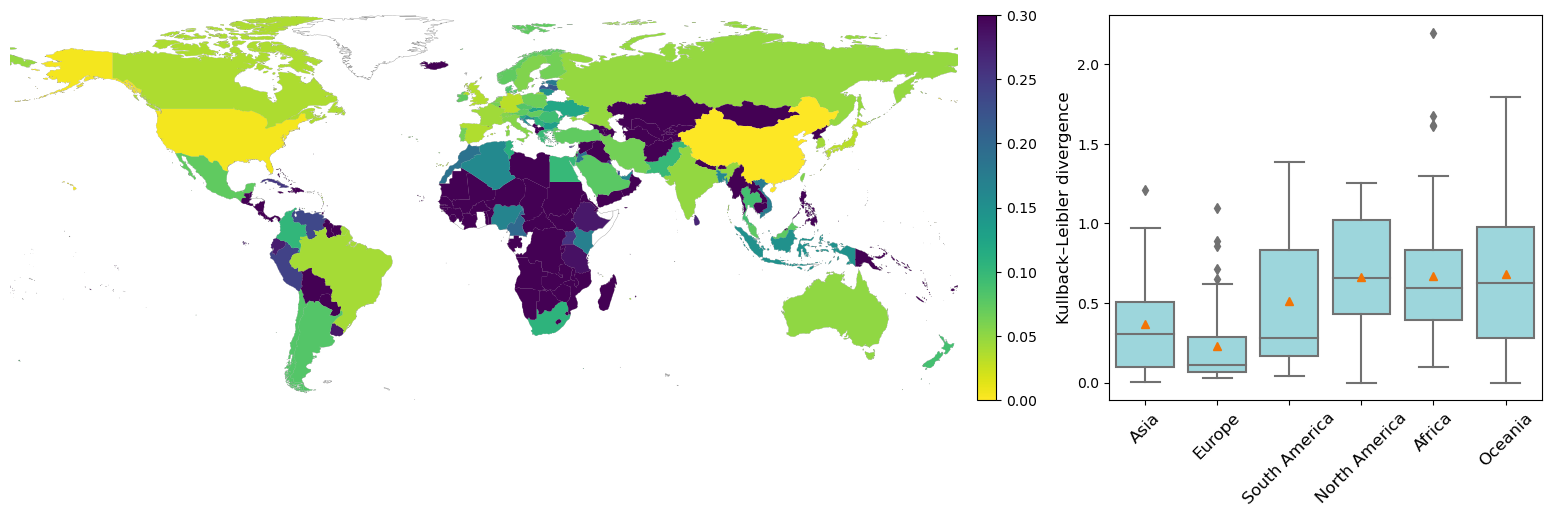

In [11]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.15},figsize=(20,5))
plot_data=world_geo.merge(result_df,left_on='WoS',right_on='country')
plot_data=gp.GeoDataFrame(plot_data)
funding.core.plot_worldmap(ax[0], fig, world_geo, plot_data, 'kl','viridis_r',0.0,0.3)
ax[0].margins(0)

orders=['Asia','Europe','South America','North America','Africa','Oceania']
sns.boxplot(x='region2',y='kl',data=result_df,color='#92DFE6',
            order=orders,ax=ax[1],showmeans=True,meanprops={"markerfacecolor":"#F27405", "markeredgecolor":"#F27405"})
ax[1].set_ylabel('Kullback–Leibler divergence',fontsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(orders,rotation=45,fontsize=12)
plt.savefig(plot_path,bbox_inches='tight')